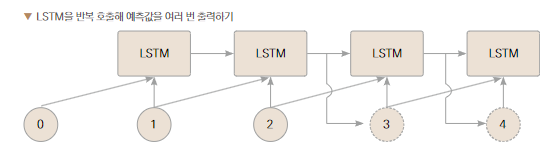

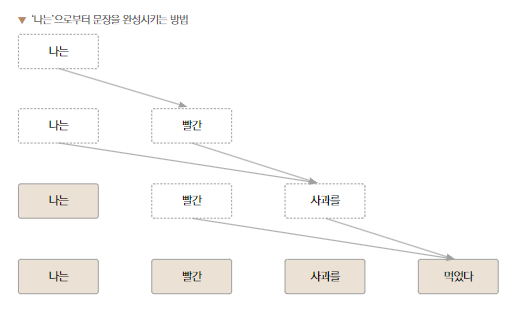

RNN
  - 가중치를 반복해서 사용해서 데이터로부터 순서정보를 획득
  - 기울기를 역전파할때 1보다 커지면 걷잡을수 없이 폭발하고 반대로 1보다 작으면 0에 가까워진다.
  - 보통 레이어의 개수는 3개나 5개로 한정된다.

LSTM
  - 장기기억을 위한 셀 상태를 추가한 모델
  - 망각게이트, 입력게이트, 출력게이트를 이용해서 이전 은닉상태를 현 시점에 반영  

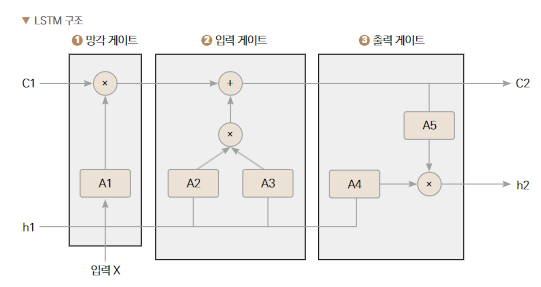

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip '/content/drive/MyDrive/data/pytorch_lstm.zip' -d lstm

Archive:  /content/drive/MyDrive/data/pytorch_lstm.zip
  inflating: lstm/CH10/ArticlesJan2017.csv  
  inflating: lstm/CH10/ArticlesFeb2017.csv  
  inflating: lstm/CH10/ArticlesJan2018.csv  
  inflating: lstm/CH10/ArticlesMarch2017.csv  
  inflating: lstm/CH10/ArticlesFeb2018.csv  
  inflating: lstm/CH10/ArticlesApril2017.csv  
  inflating: lstm/CH10/ArticlesMay2017.csv  
  inflating: lstm/CH10/ArticlesMarch2018.csv  
  inflating: lstm/CH10/ArticlesApril2018.csv  


In [ ]:
from glob import glob
file_lists = glob('/content/lstm/**/*.csv')
file_lists[3]

'/content/lstm/CH10/ArticlesFeb2018.csv'

In [ ]:
import pandas as pd
df = pd.read_csv( file_lists[3] )
df.columns

Index(['articleID', 'byline', 'documentType', 'headline', 'keywords',
       'multimedia', 'newDesk', 'printPage', 'pubDate', 'sectionName',
       'snippet', 'source', 'typeOfMaterial', 'webURL', 'articleWordCount'],
      dtype='object')

학습용 데이터 만들기
  - 1. 구두점과 특수문자를 제거
  - 2. 딥러닝 모델이 단어들을 이해하도록 사전을 만들어 단어마다 고유번호를 만듦
  - 3. 고유번호를 담고 있는 사전을 BOW라고 부름

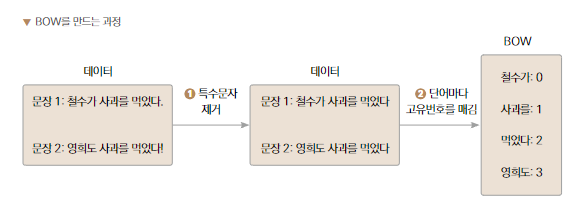

학습용 데이터셋 만들기

In [ ]:
import string
print(string.punctuation)
from torch.utils.data.dataset import Dataset

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
file_lists = glob('/content/lstm/**/*.csv')
file_lists

['/content/lstm/CH10/ArticlesMarch2018.csv',
 '/content/lstm/CH10/ArticlesApril2018.csv',
 '/content/lstm/CH10/ArticlesJan2017.csv',
 '/content/lstm/CH10/ArticlesFeb2018.csv',
 '/content/lstm/CH10/ArticlesJan2018.csv',
 '/content/lstm/CH10/ArticlesApril2017.csv',
 '/content/lstm/CH10/ArticlesMay2017.csv',
 '/content/lstm/CH10/ArticlesFeb2017.csv',
 '/content/lstm/CH10/ArticlesMarch2017.csv']

In [8]:
import numpy as np
from functools import reduce
from torch.utils.data import Dataset

class TextGeneration(Dataset):
  def __init__(self):
    file_lists = glob('/content/lstm/**/*.csv')
    all_headlines = [pd.read_csv(file).headline.values for file in file_lists]
    all_headlines = reduce(lambda x,y : list(x) + list(y), all_headlines)
    # unknown  제거
    all_headlines = [h for h in all_headlines if h != 'Unknown']
    self.corpus =  [self.clean_text(x) for x in all_headlines]  # 말뭉치
    self.BOW = {} # 단어:고유번호 형태의 딕셔너리

    for line in self.corpus:
      for word in line.split():
        if word not in self.BOW.keys():
          self.BOW[word] = len(self.BOW.keys())

    # 모델의 입력으로 사용할 데이터
    self.data = self.generate_sequence(self.corpus)
    #  BOW를 이용해서 시계열 구성
  def generate_sequence(self,txt):
    seq = []
    for line in txt:
      line = line.split()
      line_bow = [self.BOW[word] for word in line]
      # 단어 2개를 입력으로, 그 다음 단어를 정답
      data = [ ( [ line_bow[i], line_bow[i+1] ]  , line_bow[i+2]  ) for i in range(len(line_bow)-2) ]
      seq.extend(data)
    return seq

  def clean_text(self,txt):
    # 모든 단어를 소문자로 바꾸고 특수 문자를 제거
    return "".join(v for v in txt if v not in string.punctuation).lower()\

  def __len__(self):
    return len(self.data)
  def __getitem__(self, i):
    data = np.array(self.data[i][0])  #입력데이터
    label = np.array(self.data[i][1]).astype(np.float32) # 출력 데이터
    return data, label

In [12]:
import torch
import torch.nn as nn
from glob import glob
import pandas as pd
import string

dataset = TextGeneration()
data,label = next(iter(dataset))
print(data.shape)
len(dataset.BOW)  # Embedding 개수
embedding = nn.Embedding( num_embeddings=len(dataset.BOW), embedding_dim=16)
x = embedding(torch.LongTensor(data))
print('result of embedding',embedding)
lstm = nn.LSTM(
        input_size = 16,
        hidden_size = 64,
        num_layers = 10,
        batch_first=True
    )
x,_ = lstm(x)

print('result of lstm',(x.shape))

x = torch.reshape(x,(x.shape[0],-1))
x.shape  # 마지막 시퀀스에서 은닉상태와 셀 상태
#( 데이터의 배치크기, hidden_size)

(2,)
result of embedding Embedding(12148, 16)
result of lstm torch.Size([2, 64])


torch.Size([2, 64])

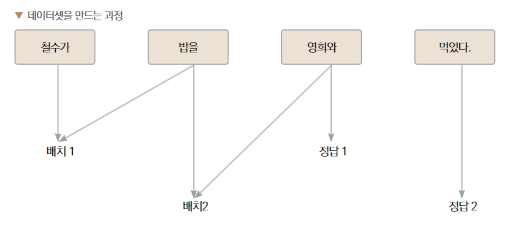

LSTM모델

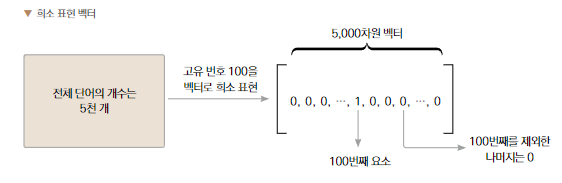

임베디드층
  - 희소표현인 입력벡터를 밀집표현으로 바꿔주는 층
  - 밀집표현은 희소벡터와 반대로 0이 거의 포함되어 있지 않는 표현 방법

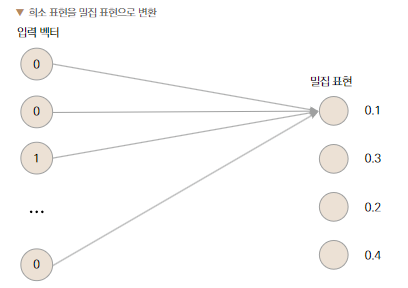

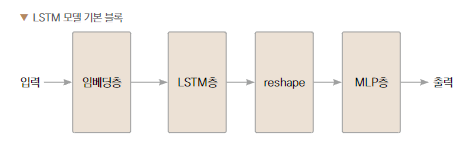

In [13]:
import torch.nn as nn
import torch
class LSTM(nn.Module):
  def __init__(self, num_embeddings):
    super(LSTM,self).__init__()
    # 밀집표현을 위한 임베딩층
    # Embedding(12148, 16)
    self.embed = nn.Embedding( num_embeddings=num_embeddings, embedding_dim=16)
    # lstm 층을 5개 쌓음
    self.lstm = nn.LSTM(
        input_size = 16,
        hidden_size = 64,
        num_layers = 5,
        batch_first=True
    )
    # 분류는 위한  MLP층
    self.fc1 = nn.Linear(128, num_embeddings)
    self.fc2 = nn.Linear(num_embeddings, num_embeddings )
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.embed(x)
    #  LSTM 모델의 예측값
    x, _ = self.lstm(x) # 첫번째값은 마지막 은닉층의 출력이고 두번째 값은 나머지 은닉층의 출력 여기서는 마지막 출력만 필요
    x = torch.reshape(x, (x.shape[0], -1))
    x = self.relu( self.fc1(x))
    x = self.fc2(x)
    return x


In [3]:
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else 'cpu'

dataset = TextGeneration()
model = LSTM(num_embeddings=len(dataset.BOW)).to(device)
loader = DataLoader(dataset, batch_size=64)
optim = Adam(model.parameters(), lr=0.001)

for epoch in range(200):
  iterator = tqdm.tqdm(loader)
  for data, label in iterator:
    optim.zero_grad()
    pred = model(torch.tensor(data,dtype=torch.long).to(device))

    loss = nn.CrossEntropyLoss()(
        pred, torch.tensor(label, dtype=torch.long).to(device)
    )
    loss.backward()
    optim.step()

    iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")
torch.save(model.state_dict(), "/content/drive/MyDrive/data/lstm.pth")


모델 성능평가

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def generate(model, BOW, string = "finding an ", strlen=10):
  with torch.no_grad():
    for p in range(strlen):
      # 입력문장을 텐서로 변경
      words = torch.tensor(
          [ BOW[w] for w in string.split() ],dtype=torch.long
      ).to(device)
      # 모델의 입력으로 사용하기 위한 배치 차원 추가
      input_tensor = torch.unsqueeze(words[-2:], dim=0 )
      output = model(input_tensor) # 모델을 이용해 예측
      output_word = (torch.argmax(output).cpu().numpy())
      string += list(BOW.keys())[output_word]
      string += " "
  print(f"predicted sentence : {string}")

model = LSTM(num_embeddings=len(dataset.BOW)).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/data/lstm.pth', map_location = device))
pred = generate(model, dataset.BOW)

predicted sentence : finding an nourishes epidemic lots labeled gone 45 now process signal cruelty 
